#  Initial Package Importation

In [568]:
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
import pandas as pd
from numpy import sort
from sklearn.datasets import make_classification
from sklearn.learning_curve import learning_curve
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score, roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
import seaborn
import urllib
from pprint import pprint
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm

import seaborn as sns




# Data Reading

In [434]:
german = pd.read_csv('german.data.csv', names=["Status", "Month", "Credit", "Purpose", "Credit_AMT", "Savings", 
                                               "Employment", "Installment", "SexMarital", "Position", "Residence", 
                                               "Property", "Age", "Other_Installment", "Housing", "Existing_Credits", 
                                               "Job", "Liability", "Phone", "Foreign", "Prediction"])

In [493]:
#We need to one-hot encode our categorical  variables. 
#Why? Even though Random Forest is one the most robust tecniques for handling a combination of data types.
#However, it can still mishandle data. So, each categorical variable is modeled as a binary feature; 0

german_one_hot_encode = pd.get_dummies(german)

In [494]:
#Investigation dictates Random Forests are able to deal with categorical variables.
#It does, however, increase computational complexity to create trees; and hence, the over all forests. 
#This means that the categorical variables  might take more importance to the different number of levels of the feature. 
#For example, the mathematical process will mistake '1, 2, 3, 4, 5' as some sort of scale.
#To combat this, we change the target class - 'Prediction', from 1 to 0, and 2 to 1. 

german['Prediction'] = german['Prediction'].map({1: 0, 2: 1})

In [495]:
##In order to produce our random forest, we first need to split our dataset and pinpoint the "grount truth". 
##A.k.a, the target class (y); the feature that shows how well the model has estimated or predicted.

#We drop the Prediction class in favour of "ground truth", hence all the other variables are left in place.

x = german_one_hot_encode.drop('Prediction', axis=1)

##Only the predictor class (ground truth) is left in the splitting.

y = german_one_hot_encode['Prediction']



In [496]:
#Here, we create a training dataset and a test dataset. The training dataset will be utilised to build and validate the model.
#The test set, on the other hand, will be "unseen" data, to uncover how well the model works with new records of data.

training_features, test_features, \
training_target, test_target, = train_test_split(x, y, test_size = 0.2,random_state=12)

In [497]:
##We split the data again only on the training features.

x_train, x_test, y_train, y_test = train_test_split(training_features,training_target, test_size=0.2)


# SMOTE Over-Sampling

In [498]:
#Indeed some confusion may arise when oversampling AFTER, rather than BEFORE. Why?
##If we opt into oversampling BEFORE splitting the training and validation, we essentially give the training model 
#a "sneak-peak" of the validation segment; ultimately producing a potentially overfitted model.
#Some of the same obervations may end up in both datasets.

##s a result, the model will predict the value for those observations when making predictions on the validation set 
#yielding relatively higher accuracy and recall.

#Why? This comes down to SMOTE's algorhtm of using 'nearest neighbour' to generate synthetic records. 
#Hence we split the data AGAIN on the training features and then accordingly fit to the SMOTE algorithm, 
#avoiding the "bleeding of data that would occur when trained on the entire dataset.

##CONLUSION: By oversampling only on the training segment, none of the information is leaked from the validation set when 
#SMOTE's nearest neighbour creates synthetic observation.

sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

# Function Definition

In [499]:
#A cross validation generator is used to select Train and Cross Validation(CV) data sets to finetune paramaters.
#The idea is to not tune paramaters against the Test dataset, there will be a certain degree of bias towards the test set,
#and hence not generalise very well.
#There will be no way of knowing how the model does not generalise well since we would have trained on all our data.

#The counteractive process is implemented below.

#General Overview: A crossvalidation generator is used to train the modek by tuning certain paramaters based on a CV set
#that is picked from the training set. A different cv set will be picked for each iteration
#The CV/Train set splits are inputted into gridsearch function that evaluates the model with each split and tune parameters
#enabling us the ability to observe the optimal parameter combination that gives the best result.

#We define this entire process as a function so that we are able to call it at anytime

def fit_trees(n_jobs, max_depth, n_estimators): 
    
#Estimator chosen as RandomForestClassifier as per initial team discussion.

    estimator = RandomForestClassifier() 

#Shuffle split is chosen to randomly shuffle and select Train and CV sets for each iteration.

    cv = ShuffleSplit(x_train_res.shape[0], n_iter=10, test_size=0.2)
    
#GridSearchCV is used to apply the CV iterator on the Training set.
#Effectively, this will allow the classifier to run on the different Train/CV splits
#Using paramaters specificied, it will return the model that has the best results.

    classifier = GridSearchCV(estimator=estimator, cv=cv, 
                              param_grid=dict(n_estimators=n_estimators, max_depth=max_depth), n_jobs=n_jobs, scoring='f1')
    
#The training dataset is fit to this classifier.

    classifier.fit(x_train_res, y_train_res)
    
#Now, we observe the best estimator/paramater combination that was located by the GridSearchCV.   
    print ("Best Estimator") 
    print (classifier.best_estimator_)
    
    return cv, classifier.best_estimator_.max_depth, classifier.best_estimator_.n_estimators 

In [500]:
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve

In [501]:
#Again, we define a function that utilises the plot_learning curve module; it is called in the next section.
#An effective visualisation tool that observes how well the model is performing based on a number of samples trained on.
#Unusual situations such as bias and high variance can be explored - discussed in the next section, as well.

def plot_learning_curve(estimator, title, x, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                    test_scores_mean + test_scores_std, alpha=0.1, color="g") 
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", 
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", 
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

In [502]:
max_depth=np.linspace(5,10,5) 
n_estimators=[10, 100, 500, 1000]

In [503]:
#Fit the Random Forest to the training dataset by calling the function we created earlier
cv,max_depth,n_estimators=fit_trees(n_jobs=10, max_depth=max_depth, n_estimators=n_estimators)

#The grid search returns an optimal fit with n_estimators =500 and max depth=6.25

Best Estimator
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6.25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


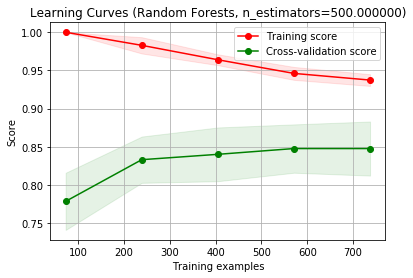

In [504]:
#Plot the learning curve to see if there exists any overfitting.
title = "Learning Curves (Random Forests, n_estimators=%.6f)" %(n_estimators) 
estimator = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=10) 
plot_learning_curve(estimator, title, x_train_res, y_train_res, cv=cv) 
plt.show() 67

#Not bad; it seems we have a resonable fit with a tinge of overfitting. 
#The training sctore (redline) is aproximately at its maximum only dropping ~5% across 800 training examples
#This implies a heavy sense of overfitting

#However, the cross validation score (green-line) increases over time.
#Despite these two lines converging, the huge gabs between the cross validation score and training score
#indicates a high variance scenario.

#This can be solved by reducing complexity or gather more data i.e PCA for reduction

# Tree based feature selection and random forest classification

In [505]:
#Calling upon fit on the estimator so that we can look at feature importances.

estimator.fit(x_train_res,y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6.25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=10,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [506]:
#Output the feature importances in order of variable input from the .csv file.

print ("German Credit Data - Feature Importances\n" )
print (estimator.feature_importances_)
print ()


Statlog Credit Data - Feature Importances

[ 0.04860032  0.03827031  0.01398527  0.02037138  0.02210999  0.00894899
  0.00741821  0.08502809  0.03729263  0.0058674   0.12579301  0.00907466
  0.00748906  0.01248704  0.00461853  0.03305461  0.01864687  0.00691248
  0.00088625  0.00756258  0.0401481   0.00046382  0.00089026  0.006478
  0.00028375  0.00299746  0.0512893   0.00538735  0.0013614   0.00211271
  0.02573206  0.00507388  0.02129524  0.00827023  0.00716119  0.00872856
  0.00371874  0.01030191  0.01817948  0.00316903  0.00561872  0.00294354
  0.00432719  0.0221876   0.00635126  0.00831086  0.01942491  0.01193411
  0.00882524  0.02548688  0.01534496  0.04672163  0.01323744  0.00063965
  0.00760133  0.01160369  0.01020247  0.01911658  0.01953887  0.00136714
  0.00175578]



Top 15 Features:
1. feature 10 (0.125793)
2. feature 7 (0.085028)
3. feature 26 (0.051289)
4. feature 0 (0.048600)
5. feature 51 (0.046722)
6. feature 20 (0.040148)
7. feature 1 (0.038270)
8. feature 8 (0.037293)
9. feature 15 (0.033055)
10. feature 30 (0.025732)
11. feature 49 (0.025487)
12. feature 43 (0.022188)
13. feature 4 (0.022110)
14. feature 32 (0.021295)
15. feature 3 (0.020371)


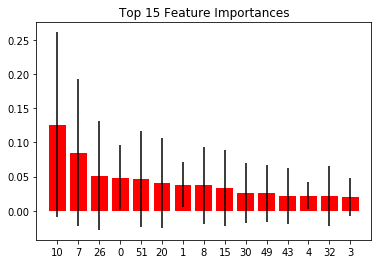

Mean Feature Importance 0.016393


In [507]:
#Calculate the feature raking - Top 15 (This is an arbitrary number)

importances = estimator.feature_importances_
std = np.std([tree.feature_importances_ for tree in estimator.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Top 15 Features:")

for f in range(15):
    print ("%d. feature %d (%f)" % (f+1, indices[f], importances[indices[f]]))
    
#Plot the top 15 feature importances of the random fores
    
indices=indices[:15]
plt.figure()
plt.title("Top 15 Feature Importances")
plt.bar(range(15), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(15), indices)
plt.xlim([-1, 15])
plt.show()

#Mean Feature Importance (this is important for transforming the features that do not meet the 'mean' threshold. )

print ("Mean Feature Importance %.6f" %np.mean(importances))

In [508]:
#It is clear that some features take a higher state of importance than others.
#In order to extract these features, we will do a form of trimming. 
#Training set is transformed to include only features that are atleast above the 'mean threshold'.

from sklearn.feature_selection import SelectFromModel

#SelectFromModel extracts these features. The mean as a threshold is set as a default paramater.

model = SelectFromModel(estimator, prefit='True')

#and then transformed onto the original data segments parsed through in the previous section.
x_train_res = model.transform(x_train_res)
x_test_r = model.transform(x_test)




In [509]:
#Calling upon fit on the estimator for the feature importances coefficient. 

estimator.fit(x_train_res,y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6.25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=10,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [510]:
#Running predictions on Test

y_pred=estimator.predict(x_test_r)

In [511]:
#74% is a fairly decent result. By dropping trimmed features by looking at feature_importances 
#we were able to get an ok-score. 

print (classification_report(y_test,y_pred))
print()
print("Final Generalisation Accuracy: %.6f" %accuracy_score(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.82      0.80      0.81       109
          1       0.59      0.63      0.61        51

avg / total       0.75      0.74      0.75       160


Final Generalisation Accuracy: 0.743750


# Feature Selection with correlation and random forest classification



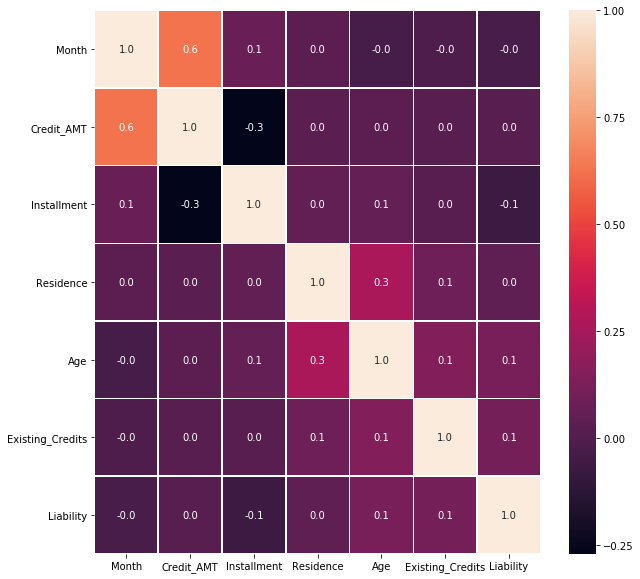

In [512]:
#As it can be seen in the heat map figure, Credit_AMT and Month are the highest correlated features sitting at 0.6


f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(german.drop('Prediction', axis=1).corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [513]:
#We drop the Month paramater because it is correlated with the Credit_AMT. 
#It seems logical to drop Month because Credit_AMT will most likely have an impact on potential default.
#Why do we do this? Correlations between features impact the feature importance measure, and the predictability of the model.
x = x.drop('Month', axis =1)


In [514]:
training_features, test_features, \
training_target, test_target, = train_test_split(x, y, test_size = 0.2,random_state=12)

In [515]:
x_train, x_test, y_train, y_test = train_test_split(training_features,training_target, test_size=0.2)

In [516]:
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [517]:
max_depth=np.linspace(5,10,5) 
n_estimators=[10, 100, 500, 1000] 

In [518]:
cv,max_depth,n_estimators=fit_trees(n_jobs=10, max_depth=max_depth, n_estimators=n_estimators)

Best Estimator
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8.75, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


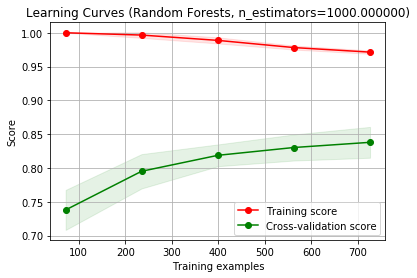

In [519]:
title = "Learning Curves (Random Forests, n_estimators=%.6f)" %(n_estimators) 
estimator = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=10) 
plot_learning_curve(estimator, title, x_train_res, y_train_res, cv=cv) 
plt.show() 

In [520]:
#78% is a lot better than the previous, but still not good enough. By dropping the Month feature, we are able to produce
#approximately 4% higher.

estimator.fit(x_train_res,y_train_res)
y_pred=estimator.predict(x_test)
print (classification_report(y_test,y_pred))
print()
print("Random Forests: Final Generalisation Accuracy: %.6f" %accuracy_score(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.81      0.91      0.86       116
          1       0.65      0.45      0.53        44

avg / total       0.77      0.78      0.77       160


Random Forests: Final Generalisation Accuracy: 0.781250


# Univariate feature selection and random forest classification

In [521]:
#In univariate feature selection, we will use SelectKBest that removes all but the k highest scoring features.

#In this method we choose how many features we will use. 
#For example, will k (number of features) be 5 or 10 or 15? The answer is only trying or intuitively. 
# k = 45 is chosen based on the Recursive feature elimination process based afterwards, as the best validation score
#given by the amount of features selected. Please see Recursive feature elimination. 

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [522]:
#The process is repeated as previously designed.

##PROCESS START

x = german_one_hot_encode.drop('Prediction', axis=1)
y = german_one_hot_encode['Prediction']

In [523]:
training_features, test_features, \
training_target, test_target, = train_test_split(x, y, test_size = 0.2,random_state=12)


In [524]:
x_train, x_test, y_train, y_test = train_test_split(training_features,training_target, test_size=0.2)

In [525]:
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [526]:
max_depth=np.linspace(5,10,5) 
n_estimators=[10, 100, 500, 1000]

In [527]:
cv,max_depth,n_estimators=fit_trees(n_jobs=10, max_depth=max_depth, n_estimators=n_estimators)

### PROCESS END.

Best Estimator
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7.5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [528]:
# find best scored 45 features

select_feature = SelectKBest(chi2, k=45).fit(x_train_res, y_train_res)

In [529]:
print('Score list:', select_feature.scores_)

Score list: [  4.58080145e+02   6.82957817e+04   2.93735004e+00   2.67991142e-01
   7.48891212e+01   2.78567349e-01   4.50511770e-01   3.61588254e+01
   1.37300966e+01   5.62715876e+00   7.15476489e+01   8.05979475e+00
   6.10159942e+00   2.46108012e+00   7.46640826e-02   2.19625376e+01
   3.80793602e+00   1.08611438e+01   3.22014486e-02   1.03311304e+00
   8.20287496e+00   1.20502515e-02   2.32293301e+00   3.46702803e+00
   2.23452617e+00   2.07612735e+00   1.20591235e+01   2.54538159e-01
   6.54060779e+00   8.65821083e+00   1.99460256e+01   1.73352159e+00
   8.51209280e+00   9.11488480e-02   9.20524361e-01   7.70511023e+00
   9.99839938e-01   2.89196015e+00   3.71910003e+00   6.94052289e-01
   1.27970471e-03   2.76451773e+00   1.62058733e+00   7.98254981e+00
   4.10774486e-01   2.46405659e+00   4.83710319e+00   5.94015375e+00
   9.35730214e-01   1.94319494e+00   1.15033430e+01   4.68153024e+00
   4.05176589e-01   4.98818243e-02   1.50662139e+00   1.48188233e-01
   4.12170116e-01   1.

In [530]:
#So lets se what happens if we use only these best scored 45 features?
x_train_res_2 = select_feature.transform(x_train_res)
x_test_2 = select_feature.transform(x_test)

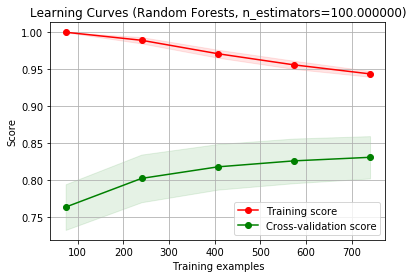

In [531]:
title = "Learning Curves (Random Forests, n_estimators=%.6f)" %(n_estimators) 
estimator = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=10) 
plot_learning_curve(estimator, title, x_train_res_2, y_train_res, cv=cv) 
plt.show() 

In [532]:
#Hmm, this is still okay. The accuracy seems to exist to be inbetween the first two models created.

estimator.fit(x_train_res_2,y_train_res)
uni_accuracy = accuracy_score(y_test, estimator.predict(x_test_2))
print (classification_report(y_test,estimator.predict(x_test_2)))
print('Unvariate Generalized Accuracy is: ', uni_accuracy)

             precision    recall  f1-score   support

          0       0.78      0.89      0.83       107
          1       0.68      0.49      0.57        53

avg / total       0.75      0.76      0.74       160

Unvariate Generalized Accuracy is:  0.75625


# Recursive feature elimination with cross validation and random forest classification

In [533]:
#Basically, the recursive feature elimination assigns weights to each of features using the random forest,
#whose absolute weights are the smallest are pruned from the current set features. 
#The procedure is recursively repeated on the pruned set until the desired number of features is outputted.

#We will not only find best features but we also find how many features do we need for best accuracy.
#A "cross-iteration" of sorts between models, we use the best  number of features in the Univariate feature selection.

from sklearn.feature_selection import RFECV

In [534]:
#Create the RFE object and rank each attribute

rfecv = RFECV(estimator=estimator, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(x_train_res, y_train_res)

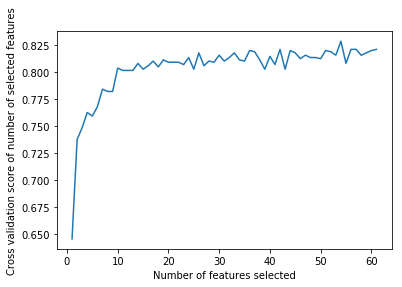

In [571]:
## Plot number of features verses the cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

#It is clear that the optimal amount of features selected out of the entire 61 would be 45 (This is the input for the
#univariate feature selection)

# Feature Exraction with PCA

In [536]:
#We will use principle component analysis (PCA) for feature extraction. 
#The idea behind PCA is we compress our original feature space into a linear dimension.
#This will reduce complexity and possibly increase the generalised accuracy.

#Before PCA, we need to normalize data for better performance of PCA.

x_train_N = (x_train-x_train.mean())/(x_train.max()-x_train.min())
x_test_N = (x_test-x_test.mean())/(x_test.max()-x_test.min())

from sklearn.decomposition import PCA

In [542]:
#A visualisation is necessary to output the variance explained throughout a plethora of components. 
#Hence, we use our entire feature space count when defining the initial PCA function.

pca = PCA(n_components = 61)

In [543]:
#Fit the normalised Training Set on to the PCA function.
train_features = pca.fit(x_train_N)

In [544]:
#Direct the variance 
variance = pca.explained_variance_ratio_ 

In [545]:
#cumulative sum of variance explained with [61] features

var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var 


array([   9.6,   16.5,   22.6,   28.3,   33.4,   38.2,   42.6,   46.6,
         50.5,   54.4,   57.9,   61.1,   64. ,   66.7,   69.2,   71.5,
         73.7,   75.8,   77.8,   79.6,   81.3,   82.9,   84.4,   85.8,
         87.1,   88.3,   89.4,   90.4,   91.3,   92.2,   93. ,   93.8,
         94.5,   95.2,   95.9,   96.5,   97.1,   97.6,   98. ,   98.4,
         98.8,   99.1,   99.4,   99.6,   99.8,   99.9,  100. ,  100.1,
        100.1,  100.1,  100.1,  100.1,  100.1])

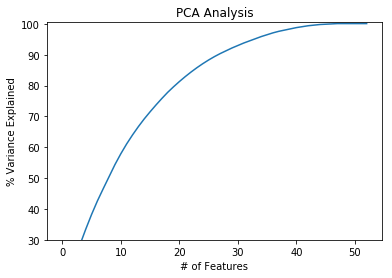

In [546]:
#In the above array we see that the first feature explains roughly 10% of the variance within our data set 
#Whilst the first two explain 16.% and so on. If we employ 45 features we capture 99.8% of the variance within the dataset, 
#thus we gain very little by implementing an additional features.

#We plot the Variance explaned across the number of features below.

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')


plt.plot(var)

#At 45, it completely plateaus.

In [547]:
#As we can see in the above PCA Analysis table, the ideal complexity remains at 45 components, rather than the full 61 features.
#We now need to extract these componenets and feed them into an entirely new Random Forest Classifier.

# initiate PCA and classifier

pca = PCA(n_components=45)
forest = RandomForestClassifier(n_estimators=500)

In [548]:
#SciKit learn has a convenient tool called Pipeline which lets you chain together transformers and a final classifier:
pipe = Pipeline(steps=[('pca', pca), ('forest', forest)])

In [549]:
#fit the pipeline with the Training Set which is applied to both the inititated pca and random forest classifier
pipe.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=45, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
        ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [550]:
#Calculate the accuracy for the original test set

test_predictions = pipe.predict(x_test)
precision = accuracy_score(test_predictions, y_test) * 100
print("Accuracy with RandomForest: {0:.6f}%".format(precision))

Accuracy with RandomForest: 70.625000%


In [551]:
#Use the pipeline in conjuction with Grid Search to obtain the best results

#Because we already know that 45 components explains 99.8& of variance, we simply leave n_components = 45.

param_dict = {"pca__n_components":[45
                                                                     
                                ],
              "forest__n_estimators":[100, 200, 500, 800]}

estimator = GridSearchCV(pipe,
                         param_dict,
                         verbose=2)

In [552]:
#Fit the GridSearch

estimator.fit(x_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] forest__n_estimators=100, pca__n_components=45 ..................
[CV] ......... forest__n_estimators=100, pca__n_components=45 -   0.3s
[CV] forest__n_estimators=100, pca__n_components=45 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ......... forest__n_estimators=100, pca__n_components=45 -   0.2s
[CV] forest__n_estimators=100, pca__n_components=45 ..................
[CV] ......... forest__n_estimators=100, pca__n_components=45 -   0.4s
[CV] forest__n_estimators=200, pca__n_components=45 ..................
[CV] ......... forest__n_estimators=200, pca__n_components=45 -   0.5s
[CV] forest__n_estimators=200, pca__n_components=45 ..................
[CV] ......... forest__n_estimators=200, pca__n_components=45 -   0.5s
[CV] forest__n_estimators=200, pca__n_components=45 ..................
[CV] ......... forest__n_estimators=200, pca__n_components=45 -   0.5s
[CV] forest__n_estimators=500, pca__n_components=45 ..................
[CV] ......... forest__n_estimators=500, pca__n_components=45 -   1.1s
[CV] forest__n_estimators=500, pca__n_components=45 ..................
[CV] ......... forest__n_estimators=500, pca__n_components=45 -   1.2s
[CV] forest__n_estimators=500, pca__n_components=45 ..................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   13.6s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=45, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
        ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [45], 'forest__n_estimators': [100, 200, 500, 800]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

In [553]:
#The best parmaters outputted with a restriction of pca_n_components = 45
#forest_n_estimators = 500

print ("The best parameters: {0}".format(estimator.best_params_))

The best parameters: {'forest__n_estimators': 500, 'pca__n_components': 45}


In [554]:
#set the identified paramaters as the best paramaters in the pipeline
pipe.set_params(**estimator.best_params_);

In [555]:
#Fit the Training data to the pipeline
pipe.fit(x_train, y_train);

In [556]:
test_predictions = pipe.predict(x_test)

In [573]:
print (classification_report(y_test, test_predictions))

precision = accuracy_score(test_predictions, y_test) * 100
print("Accuracy with RandomForest: {0:.6f}%".format(precision))

#Still yielding a poor result of 71%. It seems that there is a +- error of 10% when exploring different methods to yield 
#a higher accuracy.


             precision    recall  f1-score   support

          0       0.72      0.94      0.81       107
          1       0.68      0.25      0.36        53

avg / total       0.71      0.71      0.66       160

Accuracy with RandomForest: 71.250000%


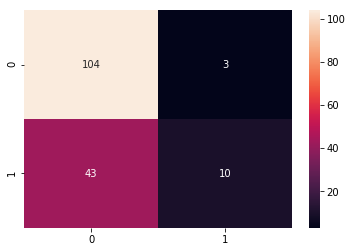

In [558]:
#confusion matrix heat map

cm = confusion_matrix(y_test, estimator.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d")

# Outlier Detection Example (LOF) with two features - Credit_AMT & AGE

In [559]:
#Read and define feature names in dataset
X = pd.read_csv('german.data.csv', names=["Status", "Month", "Credit", "Purpose", "Credit_AMT", "Savings", 
                                               "Employment", "Installment", "SexMarital", "Position", "Residence", 
                                               "Property", "Age", "Other_Installment", "Housing", "Existing_Credits", 
                                               "Job", "Liability", "Phone", "Foreign", "Prediction"])

In [560]:
#Define a "drop" array 
drop = ["Status", "Month", "Credit", "Purpose", "Savings", 
                                               "Employment", "Installment", "SexMarital", "Position", "Residence", 
                                               "Property", "Other_Installment", "Housing", "Existing_Credits", 
                                               "Job", "Liability", "Phone", "Foreign", "Prediction"]

In [561]:
#Trim everything but Credit_AMT and AGE

X = X.drop(drop, axis=1)

In [562]:
#The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point
#with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

#Import the LOF module

from sklearn.neighbors import LocalOutlierFactor

,Credit_AMT,Age
0,1169,67
1,5951,22
2,2096,49
3,7882,45
4,4870,53


In [563]:
#Define and fit the model

clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(X)
y_pred_outliers = y_pred[200:]

In [564]:
#Plot the level sets of the decision function

xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

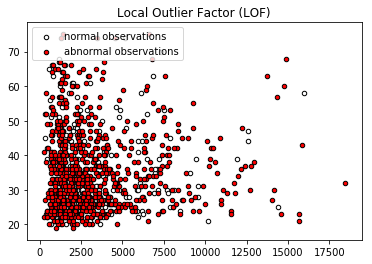

In [574]:
plt.title("Local Outlier Factor (LOF)")

#Plot the outliers
a = plt.scatter(X.iloc[:200, 0], X.iloc[:200, 1], c='white',
                edgecolor='k', s=20)

#Plot the inliers
b = plt.scatter(X.iloc[200:, 0], X.iloc[200:, 1], c='red',
                edgecolor='k', s=20)

plt.axis('tight')
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper left")
plt.show()

#We can see that there is indeed outliers, but these will have to be manually located, observed and decided whether
#they are actually outliers